# Вебинар 4. Рекоммендательные системы на основе контента. Поиск похожих товаров и пользователей

---

### 1. Общие

ALS
- На вход принимает только *позитивные* взаимодействия
- Прогнозирует **не** вероятность, а некоторые числа
- В ALS нельзя добавить внешние фичи
- ALS не учитывает сезонность / зависимость во времени (но это можно частично поправить - см далее)
- Можно использовать для ранжирования (как - см далее + вебинар 5)

### 2. Что на самом деле оптимизирует ALS

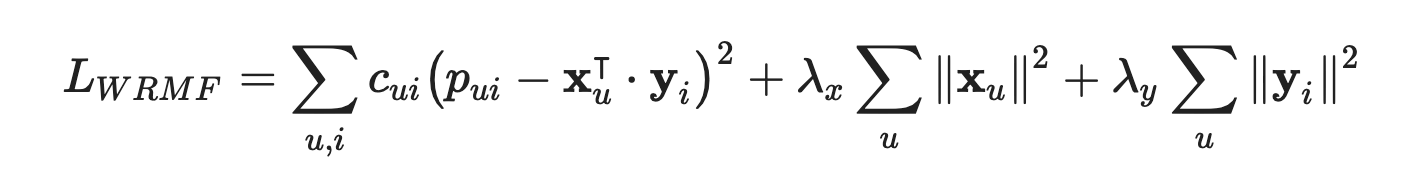

$x_u^T$ - user embeddings  
$y_i$ - item embeddings  
$p_{ui}$ - 0/1. 1 - если в матрице user-item эдемент > 0 (было взаимодействие)  
$c_{ui}$ - Вес ошибки = элемент матрицы user-item  
$\lambda_x$, $\lambda_y$ - коэффициенты регуляризации  

**Что делает ALS**
- Максимизирует скалярное произведение (dot product) между векторами user-item для позитивных interactions, минимизирует для негативных

**Скалярное призведение (dot product) VS косинусная схожесть (cosine similarity)**

$$dot(a, b) = a * b$$  
  
$$cos(a, b) = \frac{a * b}{||a||*||b||} = \frac{dot(a, b)}{||a||*||b||}$$

### 3. Как учитывать изменение вкусов потребителей во времени / изменение популярности товара во времени

- Летом юзеры любят мороженое, а зимой - нет
- Многие фильмы популярны во время проката в кино, затем их популярность снижается

*Что делать?*  
Ограничить давность взаимодейстий.  
Давать последним взаимодействиям больший вес:  

$$value_w = \sum_i value_i * \frac{1}{1 + \exp^{ \alpha*t}}$$

### 4. Как использовать для ранжирования (Краткое введение. Подробности - на следующем вебинаре)

**Вариант 1.**  
*As is* - ранжировать по output ALS

**Вариант 2.**
*Та же модель, другой лосс - BPR*

BPR - Bayesian Personalized Ranking loss
1. Случайная пара user - купленный им item_i = позитивная пара
2. Для того же юзера сэмплируем item_j (не купил или вес в user-item матрице ниже, чем у item_i из 1.) - негативная пара
3. Прогнозы модели $p_{ui}$, $p_{uj}$ --> $p_{ui} - p_{uj}$
4. loss = $\sigma(p_{ui} - p_{uj})$ - это и есть наша ошибка
5. Обновляем эмбеддинги

In [1]:
from implicit.bpr import BayesianPersonalizedRanking

Синтаксис такой же как у AlternatingLeastSquares. ML модель такая же, лосс - BPR

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items

In [3]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)

test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
item_features = pd.read_csv('product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [5]:
n_items_before = data_train['item_id'].nunique()

data_train = prefilter_items(data_train, item_features=item_features, take_n_popular=5000)

n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 86865 to 5001


In [6]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [7]:
result = result.loc[result['user_id'] != 1984]
result = result.loc[result['user_id'] != 2259]

In [8]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

user_item_matrix.head(3)

item_id,117847,818981,819255,819308,819400,819487,819590,819594,819840,819845,...,15926775,15926844,15926886,15972074,15972298,15972565,15972790,16100266,16729299,16729415
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [10]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [11]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in model.recommend(userid=userid_to_id[user],  # userid - id от 0 до N
                           user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                           N=N, # кол-во рекомендаций 
                           filter_already_liked_items=False, 
                           filter_items=[itemid_to_id[999999]], 
                           recalculate_user=False)]
    return res

In [36]:
%%time

model = BayesianPersonalizedRanking(factors=20, 
                                regularization=0.01,
                                learning_rate=0.01,
                                iterations=25, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)


Wall time: 563 ms


In [13]:
%%time
result['bpr_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

print("Precision:",result.apply(lambda row: precision_at_k(row['bpr_bm25'], row['actual']), axis=1).mean())

Precision: 0.1084313725490188
Wall time: 6.31 s


In [14]:
%%time

model = AlternatingLeastSquares(factors=20, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)


Wall time: 686 ms


In [15]:
%%time
result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

print("Precision:",result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean())


Precision: 0.09539215686274458
Wall time: 6.25 s


In [16]:
result.head(10)

,user_id,actual,bpr_bm25,als_bm25
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1127831, 916122, 866211, 878996, 901062]","[1082212, 885290, 8090541, 1083043, 1029272]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1044078, 1106523, 844179, 1029743, 8090537]","[1044078, 844179, 1106523, 1029743, 12810393]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[878996, 1127831, 866211, 916122, 854852]","[1026118, 857006, 1082185, 933637, 878996]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[916122, 866211, 1127831, 1029743, 878996]","[1039627, 1100140, 912817, 9803591, 5981267]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[916122, 5569230, 844179, 1029743, 866211]","[916122, 981660, 906844, 919535, 844179]"
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[1044078, 844179, 1029743, 5569230, 866211]","[988736, 901067, 5568845, 6979579, 1019247]"
6,13,"[6534178, 1104146, 829197, 840361, 862070, 884...","[1127831, 916122, 866211, 878996, 1029743]","[1014458, 8090532, 1075368, 9487885, 955867]"
7,14,"[840601, 867293, 933067, 951590, 952408, 96569...","[1044078, 1106523, 844179, 1029743, 8090537]","[910673, 1025611, 1127758, 846823, 972143]"
8,15,"[910439, 1082185, 959076, 1023958, 1082310, 13...","[1127831, 878996, 866211, 916122, 854852]","[933637, 1026118, 1082185, 1042616, 970160]"
9,16,"[1062973, 1082185, 13007710]","[916122, 866211, 1029743, 844179, 1044078]","[954495, 1100533, 1016260, 1063739, 1017325]"


----

# Альтернативные способы предсказаний

### Кейс 1. Продажи товаров собственной торговой марки (СТМ)

У многих ритейлеров есть товары СТМ:
    - Азбука Вкуса - Просто Азбука
    - Ашан - Каждый день
    - ВкусВилл - ВкусВилл
    - ...
    
Как правило, у них маржинальность (~прибыль) > обычные товары.   
Как сделать так, чтобы юзеры переключились на товары СТМ? - *рекоммендации!*

*Нужно заменить те товары, которые пользователь уже покупает, на товары СТМ*

In [17]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [18]:
item_features = item_features[item_features['item_id'].isin(itemid_to_id.keys())]
item_features[item_features['brand'] == 'Private'].item_id.nunique()

788

In [19]:
own_items = item_features[item_features['brand'] == 'Private'].\
    groupby('department')['item_id'].nunique().\
    sort_values(ascending=False)
own_items

department
GROCERY          482
MEAT-PCKGD        89
DRUG GM           49
DELI              47
SEAFOOD-PCKGD     38
PASTRY            38
PRODUCE           25
NUTRITION         11
MEAT               7
FLORAL             2
Name: item_id, dtype: int64

In [20]:
categories_with_own_items = own_items.index.tolist()

In [21]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42, n_iter=300, n_iter_without_progress=20)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [37]:
model.item_factors.shape

(5001, 21)

In [38]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

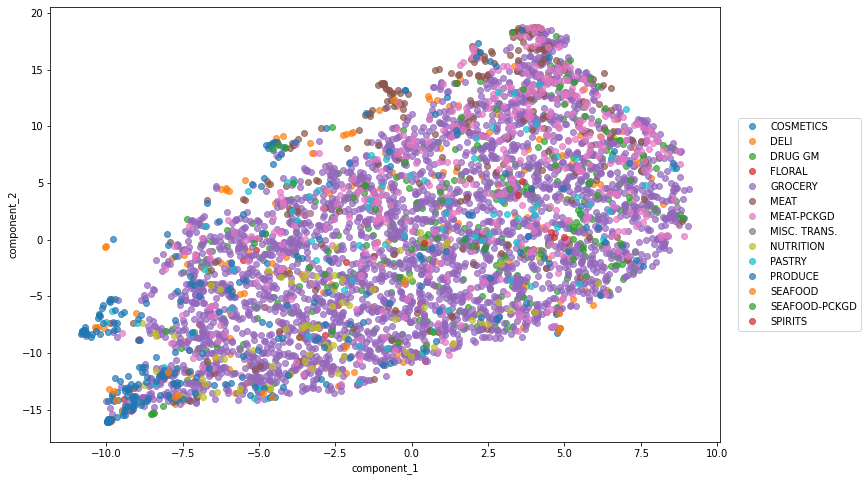

Wall time: 4.64 s


In [39]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne')
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne['item_id'] = list(itemid_to_id.keys())
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

In [40]:
item_emb_tsne_reduced = item_emb_tsne[item_emb_tsne['category'] != 'GROCERY']

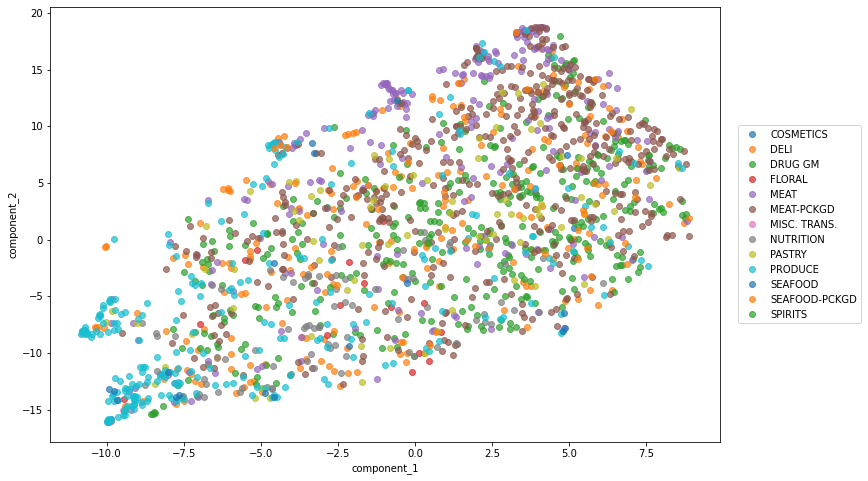

In [41]:
display_components_in_2D_space(item_emb_tsne_reduced, labels='category')

Нарисуем все товары в категориях, где есть СТМ

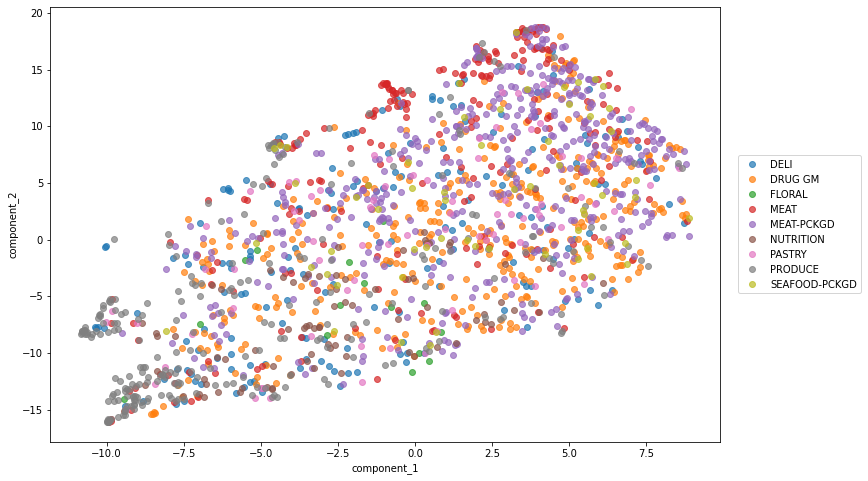

In [42]:
display_components_in_2D_space(item_emb_tsne_reduced[item_emb_tsne_reduced['category'].isin(categories_with_own_items)], 
                               labels='category')

In [43]:
similar_items = model.similar_items(itemid_to_id[1004906], N=50)
similar_items = [id_to_itemid[sim[0]] for sim in similar_items]
similar_items.append(1004906)

In [44]:
item_emb_tsne[item_emb_tsne['item_id'] == 1004906]

,component_1,component_2,category,item_id
2093,-1.495481,11.126945,PRODUCE,1004906


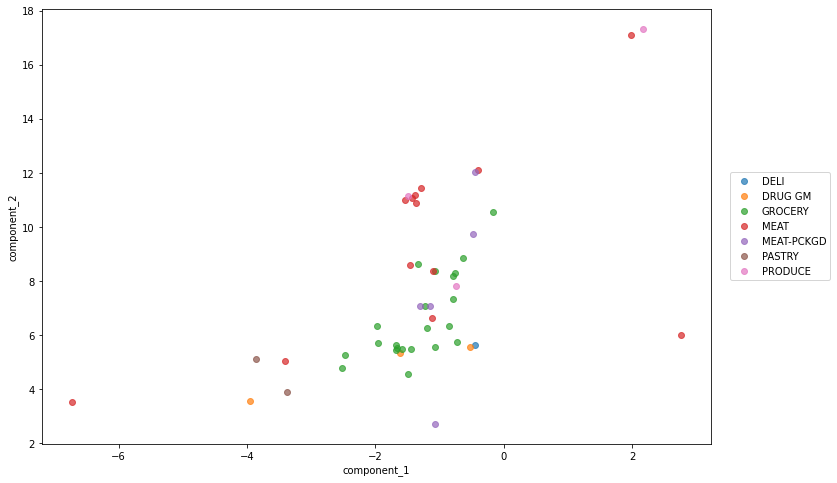

In [45]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['item_id'].isin(similar_items)], 
                               labels='category')

Берем топ-5 популярных покупок юзера --> находим по 1 наиболее близкому товару СТМ для них --> рекомендуем

In [50]:
# your_code

popularity = data_train.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
popularity.sort_values('quantity', ascending=False, inplace=True)

popularity = popularity[popularity['item_id'] != 999999]

popularity = popularity.groupby('user_id').head(5)

popularity.sort_values(by=['user_id','quantity'], ascending=False, inplace=True)
popularity.head(10)

,user_id,item_id,quantity
333227,2500,1065538,10
333226,2500,1063739,8
333274,2500,6534030,5
333121,2500,854405,4
333202,2500,1013389,4
333053,2499,1070820,19
333079,2499,5570048,7
333076,2499,5568378,6
333050,2499,1060872,5
332981,2499,899624,5


In [51]:
%%time

def get_rec_similar_items(model, x):
    recs = model.similar_items(itemid_to_id[x], N=2)
    top_rec = recs[1][0]
    return id_to_itemid[top_rec]
    

popularity['similar_recommendation_bpr'] = popularity['item_id'].apply(lambda x: get_rec_similar_items(model, x))
popularity.head(3)

Wall time: 754 ms


,user_id,item_id,quantity,similar_recommendation_bpr
333227,2500,1065538,10,1034176
333226,2500,1063739,8,1010766
333274,2500,6534030,5,993044


In [52]:
recommendation_similar_items = popularity.groupby('user_id')['similar_recommendation_bpr'].unique().reset_index()
recommendation_similar_items.columns=['user_id', 'similar_recommendation_bpr']
recommendation_similar_items.head(2)

,user_id,similar_recommendation_bpr
0,1,"[9831882, 5582712, 1127328, 9297461, 6514259]"
1,2,"[8090509, 5585510, 5569845, 999999, 819978]"


In [53]:
result_predict = result.merge(recommendation_similar_items, on='user_id', how='inner')
result_predict.head(2)

,user_id,actual,bpr_bm25,als_bm25,similar_recommendation_bpr
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1127831, 916122, 866211, 878996, 901062]","[1082212, 885290, 8090541, 1083043, 1029272]","[9831882, 5582712, 1127328, 9297461, 6514259]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1044078, 1106523, 844179, 1029743, 8090537]","[1044078, 844179, 1106523, 1029743, 12810393]","[5585510, 1075470, 880664, 870547, 907631]"


In [54]:

from metrics import precision_at_k

# result.apply(lambda row: precision_at_k(row['similar_recommendation'], row['actual']), axis=1).mean()
result_predict.apply(lambda row: precision_at_k(row['similar_recommendation_bpr'], row['actual']), axis=1).mean()

0.01842364532019703

### Кейс 2. Вашим друзьям нравится / Похожим пользователям нравится / ...

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [55]:
userid_to_id[10]

9

In [56]:
model.similar_users(userid_to_id[10], N=6)

[(9, 0.9999999),
 (688, 0.99689025),
 (2120, 0.9968806),
 (2399, 0.99631727),
 (2029, 0.99622226),
 (251, 0.9960032)]

In [57]:
%%time

own = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей

own.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)


Wall time: 129 ms


In [58]:
get_recommendations(user=1, model=own, N=1)

[856942]

In [ ]:
# your_code

# Добавка к Content-based 

- по картинкам

- по текстам (описания товаров, комментарии, заголовки)

Получаем вектора по-любому контенту и дальше считаем KNN

-----

# Production

In [ ]:
def prefilter_items(data):
    # Уберем самые популярные товары (их и так купят)
    popularity = data_train.groupby('item_id')['user_id'].nunique().reset_index() / data_train['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    
    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    
    # Уберем не интересные для рекоммендаций категории (department)
    
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    
    # Уберем слишком дорогие товарыs
    
    # ...
    
def postfilter_items(user_id, recommednations):
    pass

In [ ]:
def get_recommendations(user, model, sparse_user_item, N=5):
    """Рекомендуем топ-N товаров"""
    
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]],  # !!! 
                                    recalculate_user=True)]
    return res

In [ ]:
def get_similar_items_recommendation(user, model, N=5):
    """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""
    
    # your_code
    
    return res

In [ ]:
def get_similar_users_recommendation(user, model, N=5):
    """Рекомендуем топ-N товаров, среди купленных похожими юзерами"""
    
    # your_code
    
    return res

Все эти функции отправим затем в *src.**

----